# Signal processing

In [1]:
import json
import urllib

import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot, layout, row
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import figure
from scipy import fft, integrate, signal

output_notebook()

temp_path = "https://cdn.jsdelivr.net/gh/LarsHenrikNelson/PatchClampHandbook/data/current_clamp/"
with urllib.request.urlopen(temp_path + "11.json") as url:
    temp = json.load(url)
    data = np.array(temp["array"])

temp_path = (
    "https://cdn.jsdelivr.net/gh/LarsHenrikNelson/PatchClampHandbook/data/mepsc/"
)
with urllib.request.urlopen(temp_path + "1.json") as url:
    temp = json.load(url)
    mepsc = np.array(temp["array"])

def format_ax(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(which="both", color="0.95")

Loading BokehJS ...

In this chapter we will cover what I consider core signal processing techniques such as convolution, filtering, FFT, peak finding, derivatives and integrals.

## Derivatives and integrals
We will start with derivatives and integrals of descrite signals. Derivatives and integrals are some of the simplest signal processing that we can do. While derivatives and integrals may seem like intimidating calculus they are actually pretty simple for discrete data. 

### Derivatives
#### How to take a discrete derivative
If you remember from calculus that the derivative is defined by: $$L=\lim _{h\to 0}{\frac {f(a+h)-f(a)}{h}}$$ This means that we take the slope between each set of values. For continuous data that means there are an infinite number of differences but, for discrete data there are discrete points which means that we can just take the difference between neighboring points for our x and y data. Numpy has a built in function to do this called [diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html). If you have evenly spaced data as is for most data that we collect in the digital realm you dy is technically just `y[1]-y[0]`. If you want to get fancy you can use some called forward, central, or backward differences. In Numpy there is a func called [gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html#numpy-gradient) that calculates the second order difference, which if you have evenly spaced data is just this equation: $$\hat f_{i}^{(1)}=\frac{f\left(x_{i+1}\right) - f\left(x_{i-1}\right)}{2h}+ \mathcal{O}\left(h^{2}\right)$$ The second order difference just means that you grab the points to each side of the current index and find the slope between those. The gradient is nice because you end up with an output that is the same size as the input. The drawback is that if you have a signal with small peaks you will lose a lot of the variability in your signal. One way around that is to upsample your signal.
#### When is a derivative useful?
The derivative has many uses. The derivative of voltage signals can be used to transform it into current signals if you are recording voltage from a capacitor (a cell can be considered a capacitor). You can use derivatives to detrend signals. Many statistical algorithms used to analyze signals assume something called stationarity which means that a signal has a relatively constant mean and variance over time. The discrete derivative is a great way to create a stationary signal. We can use the derivative to find specific features of a signal like in the [current clamp chapter](#cc_pt1) where we used the derivative to find the spike threshold. You could correlate the derivatives instead of the actual signal this will help find where there are overlapping rates of change.

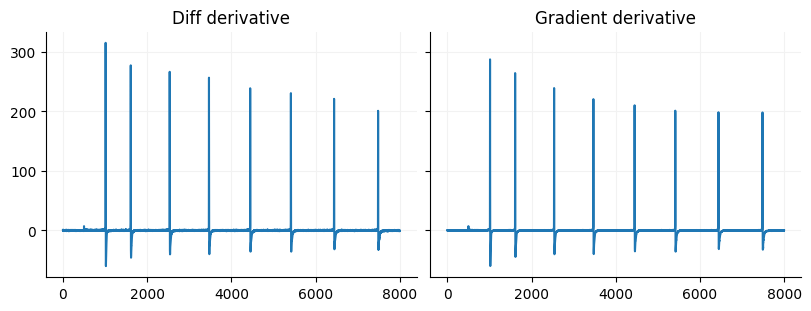

In [2]:
dy = np.diff(data)
dx = np.diff(np.arange(data.size) / 10)
derivative = (dy / dx)[2500:10500]
fig, ax = plt.subplots(ncols=2, figsize=(8, 3), constrained_layout=True, sharey=True)
ax[0].plot(np.arange(derivative.size), derivative)
ax[0].set_title("Diff derivative")
gradient = np.gradient(data, np.arange(data.size) / 10)[2500:10500]
ax[1].plot(np.arange(gradient.size), gradient)
ax[1].set_title("Gradient derivative")
for a in ax:
    format_ax(a)

### Cumulative integrals
Cumulative integrals are just the reverse of the discrete derivative. If you use [diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) on a signal you can get the orignal signal back by using Numpy [cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html#numpy-cumsum) as long as you know the original value of the first sample. If you use Numpy [gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html#numpy-gradient) there is no way to recover the original signal but you can approximate it using Scipy's [cumulative-trapezoid](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html) or [cumulative_simpson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_simpson.html#scipy.integrate.cumulative_simpson) and adding the original value of the first sample. For both ways if you want to fully recover the signal you need the value of the first sample of the original signal or the constant offset.

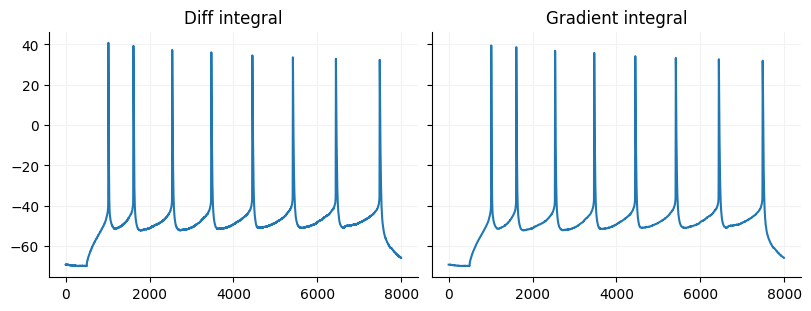

In [3]:
diff_int = np.r_[data[2500], data[2500] + np.cumsum(derivative) * 0.1]
fig, ax = plt.subplots(ncols=2, figsize=(8, 3), constrained_layout=True, sharey=True)
ax[0].plot(np.arange(diff_int.size), diff_int)
ax[0].set_title("Diff integral")
grad_int = integrate.cumulative_simpson(gradient, dx=0.1) + data[2500]
ax[1].plot(np.arange(grad_int.size), grad_int)
ax[1].set_title("Gradient integral")
for a in ax:
    format_ax(a)

### Discrete integral (area under the curve)
Another way to intgrate you signal is to get the area under the curve (AUC). AUC is often used for analyzing photometry signals, can used to analyze the area under a spike (a proxy of spike width) among other applications. To integrate signals you can use Numpy [trapezoid](https://numpy.org/doc/stable/reference/generated/numpy.trapezoid.html), Scipy [simpson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html#scipy.integrate.simpson), or Scipy [trapezoid](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html#scipy.integrate.trapezoid). If you want to see integration in action you can look at the [current clamp chapter](#cc_pt1)

In [4]:
print(f"Trapezoid: {integrate.trapezoid(data)}")
print(f"Simpson: {integrate.simpson(data)}")

Trapezoid: -1224310.38891142
Simpson: -1224311.537062173


## Convolution
Convolution is one the most used signal processing algorithms. It is used in filtering, template matching (which is a type of filtering), spike cross-correlation (different from Pearson's correlation) and is the core of convolution neural networks. We are going to focus on 1D convolution. If you have gone through the mspc chapter you have seen template matching (a version of convolution) used to find PCS. 

The basic idea of convolution is you are weighting an input array with a template and sliding that template over your input array. You can also think of it a getting the sliding area under the curve that is shared by both signals. If you want to do correlation you just reverse your template. The real definition of [convolution on Wikipedia](https://en.wikipedia.org/wiki/Convolution) is stated as "taking the integral of the product of two functions after one is reflected about the y-axis and shifted". I recommend looking at the visual explanation on Wikipedia. Just note that for discrete signals the functions are just the signals.

### Time domain convolution
Below you can see an implementation of time domain convolution in Python. What happens is that for each value in one array you multiply all the values in the second array and add it to an output array. Time domain convolution outputs an array whose length equals `len(input) + len(template) - 1`. The additive length of your output means your signal is shifted in time by len(template)/2. There are several ways you can output time domain convolution. You can output the arrays only where there is 100% overlap overlap between the two. You can output the full output like I have done below. You can output the same length. For most electrophysiological signal processing we want the same length output. However, there are several ways you can output the same length. One is to get the "zero phase" output by subset the array like this `output[template.size//2:input.size+template.size//2]` or you can just grab

### Frequency domain convolution
For frequency domain convolution you need to run the forward FFT on both of your arrays. You will need to zero-pad your shortest array to the same length as the longer array. Once you have the forward FFT of both signals you just do element-wise multiplication then you take the resulting array and do the backward FFT. One thing to note is that if your input signals are real you can run a faster version of the FFT. The FFT convolution will output an array of length equal to the longest array even if you zero-pad your signal. 

### Comparing the convolutions
Below you can see a comparison of the two by convolving an array of noise with a gaussian curve (a common way to filter a signal).

In [5]:
def time_convolution(array1, array2):
    output = np.zeros(array1.size + array2.size - 1)
    for i in range(array1.size):
        for j in range(array2.size):
            output[i + j] += array1[i] * array2[j]
    return output


def fft_convolution(array1, array2):
    size = fft.next_fast_len(max(array1.size, array2.size))
    output = fft.irfft(fft.rfft(array1, n=size) * fft.rfft(array2, n=size))
    return output

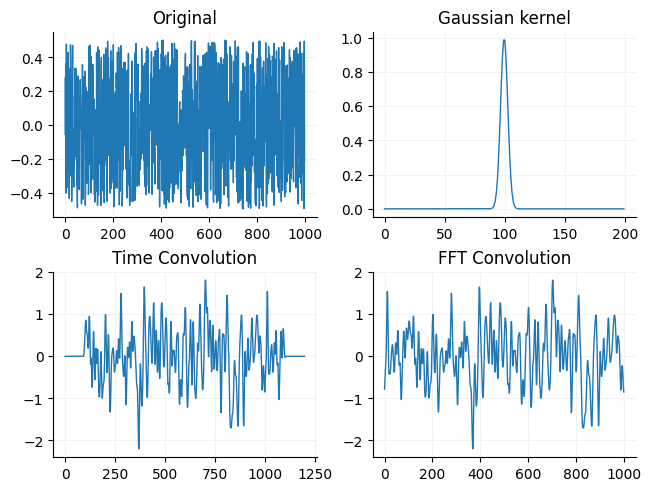

In [6]:
rng = np.random.default_rng(42)
array1 = rng.random(1000)
array1 -= array1.mean()
array2 = signal.windows.gaussian(200, 3)
tconv = time_convolution(array1, array2)
fconv = fft_convolution(array1, array2)
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
ax = ax.flat
ax[0].plot(array1, linewidth=1)
ax[0].set_title("Original")
ax[1].plot(array2, linewidth=1)
ax[1].set_title("Gaussian kernel")
ax[2].plot(tconv, linewidth=1)
ax[2].set_title("Time Convolution")
ax[3].plot(fconv, linewidth=1)
ax[3].set_title("FFT Convolution")
for i in ax:
    format_ax(i)

You may notice that the original signal looks fuzzier than than the convolved signal. This is because the gaussian kernel acts as a simple low pass filter (reduces gain of high frequencies but leaves low frequency gain mostly the same).

### Convolution applications
Convolution can be used for filtering, which we will cover below, or for template matching (also called correlation). In the [m/sPSC chapter](#mspsc_pt1) we used template matching (correlation) to find events. Template matching is also used to find spikes for in-vivo electrophysiology, you can use template matching to find features in an image such as in convolution neural networks and you can use convolution to turn point processes into synthetic data. 

## Filtering
Filters that we typically use come in a couple types: IIR filters, FIR filters, convolution filters and moving window filters. When we talk about designing filters, you may come across 4 main types of filters: lowpass, highpass, bandpass and notch filters. Lowpass filters let low frequency signals pass and attenuate (reduce the gain/power) of high frequency signals. Highpass filters let high frequencies signals pass and attenuate low frequency signals. Bandpass filters attenuate both low and high frequencies but let frequenceis inbetween a set of frequencies pass such as 300-6000 Hz bandpass that can be used to isolate single unit spikes. Notch filters let most low and high frequency signals pass but typically attentuate a small frequency band such 58-62 Hz to remove line noise (at least in the US). The frequencies that filters let through unattenuated are considered the passband of the filter and the stopband is considered where the frequencies are fully attenuated by the filters (amount of attenuation depends on the filter). Most filters, particularly the ones we use, have a roll off which means that there is some set of frequencies that will be partially attenuated. Ripple is considered unwanted change in gain in the passband and stopband of a filter. Filters can also cause ripple in the time domain signal which means the filter is just introducing time-decaying oscillations into the signal which is usually unwanted. Filters with sharp cutoffs are more likely to have ripple and cause ringing.

### Convolution filters
Convolution filters are essentially convolving one array with another like we convolved the random noise data with a gaussian filter. Additionally, many FIR filters are just convolution filters. Simple convolution filters typically just filter out high frequency content.

### Moving window filters
Moving window filters are things like a sliding median or mean. Moving window filters typically act as lowpass filters. They are good for when your data is not sampled in the typical Hertz range but in days, hours, etc. For example you might use a moving mean to smooth stock price data or sales data. Moving window filters can shorten your data since your aggregating your data, however there are ways to make sure your signal is the same length. Moving window filters can also change the phase of your signal. The larger the window the more potential there is for phase change.

#### Moving mean filter

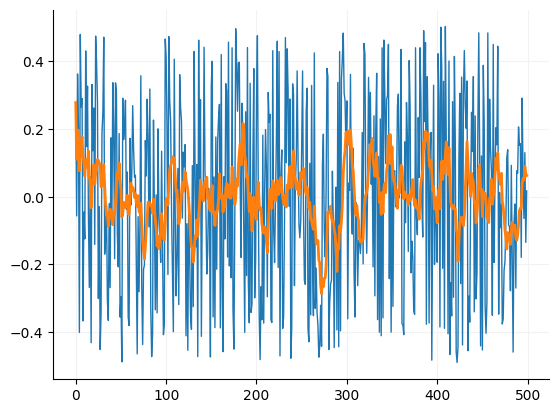

In [7]:
rng = np.random.default_rng(42)
array1 = rng.random(500)
array1 -= array1.mean()
window_size = 10
mov_mean = np.zeros(array1.size)
for i in range(1, array1.size+1):
    j = i -1
    if j < window_size:
        mov_mean[j] = array1[:i].mean()
    else:
        mov_mean[j] = array1[i-10:i].mean()
fig, ax = plt.subplots()
ax.plot(array1, linewidth=1)
_ = ax.plot(mov_mean, linewidth=2)
format_ax(ax)

### Infinite impulse response (IIR) and minimal-phase filters (primarily the Bessel and Butterworth filters)
IIR filters as their name implies have an impulse response that is infinitely long and have internal feedback. In Python they including digital versions of analog filters such as the Bessel and Butterworth filter. The Bessel and Butterworth filter are probably the most commonly used filters in electrophysiology. IIR filters are consider minimal-phase filters which means they disrupt the phase (oscillations) of the signal by introducing a frequency dependent delays in the signal. The Bessel and Butterworth filters have very little ripple or change in gain in frequencies due to the filter. Bessel and Butterworth filters basically are tradeoffs between ripple, the steepness of the filter cutoff and the phase delay. When designing these filters in Python we generally just need to supply the what type of passband we want (lowpass, highpass, bandpass) and the order of the filter. The order of the filter is the steepness of the cutoff between the passband and stopband. In Python there are several different computation ways to create and use these filters. You can use an A/B filter, SOS filter or create an impulse response and convolve the filter. Unless you need GPU acceleration I recommend the SOS filter since it is numerically stable compared the A/B filter and impulse response filter. While Bessel and Butterworth filters change the phase of your signal, in the digital realm we can filter the signal in two directions which removes the phase changes but filters your data twice which squares the magnitude of the filter.

To create a filter in python you can use the Scipy function [bessel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bessel.html) or [butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html). These offer simple interface for creating a bessel or butterworth filter.

#### Frequency response of different Butterworth filters

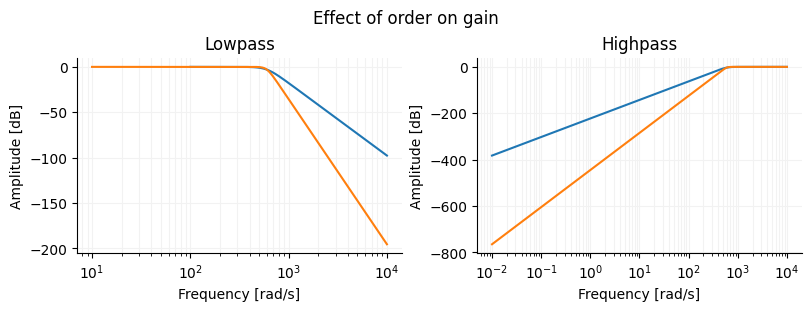

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3), constrained_layout=True)
fig.suptitle("Effect of order on gain")
ax[0].set_title("Lowpass")
ax[1].set_title("Highpass")
for i in ax:
    format_ax(i)
    i.set_xlabel("Frequency [rad/s]")
    i.set_ylabel("Amplitude [dB]")
for j in [
    (4, 600, "lowpass"),
    (8, 600, "lowpass"),
]:
    b, a = signal.butter(N=j[0], Wn=j[1], btype=j[2], analog=True)
    w, h = signal.freqs(b, a)
    w, h = signal.freqs(b, a)
    ax[0].semilogx(w, 20 * np.log10(abs(h)))
for j in [
    (4, 600, "highpass"),
    (8, 600, "highpass"),
]:
    b, a = signal.butter(N=j[0], Wn=j[1], btype=j[2], analog=True)
    w, h = signal.freqs(b, a)
    w, h = signal.freqs(b, a)
    ax[1].semilogx(w, 20 * np.log10(abs(h)))

#### Effect of filtering on phase using a Butterworth filter
Below is an example of how filtering effects a signal using an SOS filter. Scipy gives the option of filting in just one direction (filt) or in both directions (filtfilt). If you want a traditional filter use filt otherwise I recommend using filtfilt.

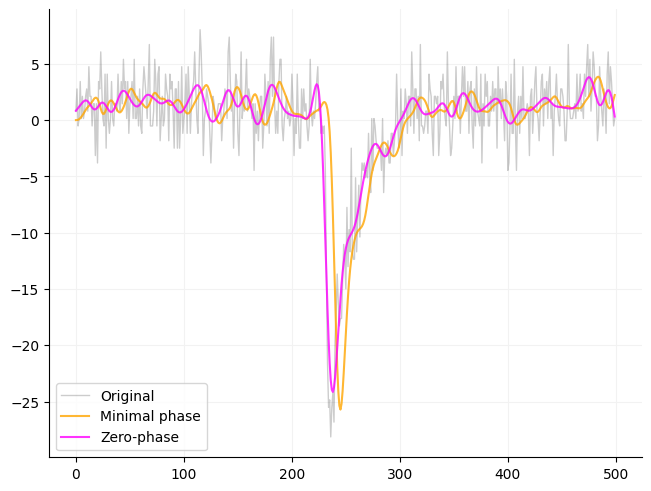

In [11]:
array1 = mepsc[2750:3250].copy()
array1 -= array1.mean()
high = signal.butter(4, 600, btype="lowpass", output="sos", fs=10000)
single = signal.sosfilt(high, array1)
double = signal.sosfiltfilt(high, array1)
x = np.arange(single.size)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(x, array1, color="black", linewidth=1, alpha=0.2, label="Original")
ax.plot(x, single, color="orange", alpha=0.8, label="Minimal phase")
ax.plot(x, double, color="magenta", alpha=0.8, label="Zero-phase")
_ = ax.legend()
format_ax(ax)

### Finite impulse response (FIR) and linear-phase filters
FIR filters are purely digital filters whose impulse response goes to zero in a finite amount of time, hence the name finite impulse response. Since FIR filters go to zero they also have finite length. FIR filters are considered linear phase which means they do not affect the phase of the signal in passband but can have variable phase disruptions in the stopband. Linear phase response is extremely useful for telecommunications applications or other applications where you want predictable phase changes. The most common FIR filters are a sinc function window by a window such as the gaussian or Hann window to ensure the filter response goes to zero. FIR filters have an order which is basically the length in samples of the filter. FIR filters are also known to cause ringing, however this can be minimized with longer filters and choice of window.

#### The Sinc filter
The [sinc filter](https://en.wikipedia.org/wiki/Sinc_filter) is essentially an ideal filter that removes all frequencies above or below the cutoff frequency (like a brickwall). This is just a rectangle in the frequency domain. In practice this type of filter is unstable and when converted to the time domain is infinitely long. To get around the problems of using the sinc filter we window sinc filters and other FIR filters.

#### Windows
Windows are used to ensure FIR filters actually go to zero. Whether you are using a sinc filter or a design a filter in the frequency domain a window will improve the filter. The choice of window for an FIR filter can impact your signal. Windows generally trade off between filter cutoff, transition band width and sideband ripple. Sideband ripple unevenly reduces the amplitude of frequencies after the cutoff. [_The scientist and engineer's guide to digital signal processing_](https://www.dspguide.com/ch16/1.htm) recommends a Blackman window. However, if you want precision above all else you can design a Kaiser window.

#### Designing a FIR filter
When designing a FIR filter you have several considerations: precision of the filter, sideband ripple, attenuation after the cutoff, transition band width. You will want a longer filter the steeper the cutoff or more narrow the width between passband and stopband. Sideband ripple is primary effected by the choice of window for the FIR filter. You can compare them to see what works best. If you want a precise filter then use a Kaiser window. The Kaiser window makes it easy to compare between the cutoff width, attenuation and filter length.

#### Creating an FIR filter in Python
Scipy has two function [firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html#scipy.signal.firwin) and [firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html#scipy.signal.firwin2). If you need flexibility in specifying the gain structure of your signal then use firwin2 since firwin you can chooose width of the cutoff region or window but not both. If you want a simple easy to use filter, use the firwin with a specified cutoff is probably the easiest and will work in most situations since is uses a Kaiser window (pretty precise) if you provide a cutoff width. Firwin2 need to have the gain provided for each frequency. This can be useful is you want to have gains that are not 0 and 1 and that vary by frequency such as for designing a multiband equalizer.

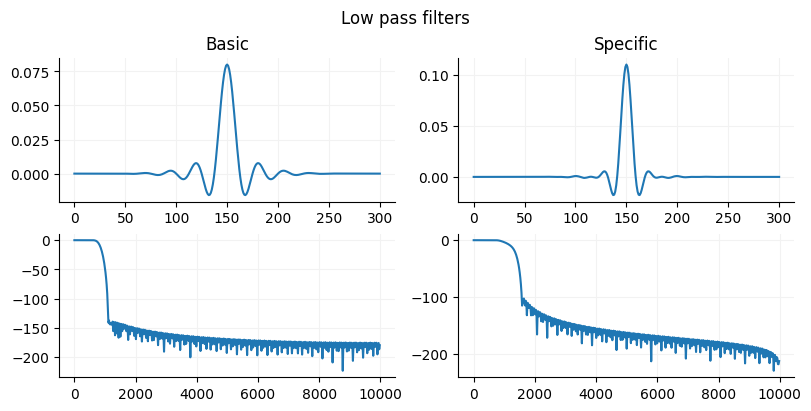

In [12]:
basic_filter = signal.firwin(301, 400, width=300, fs=10000)
complex_filter = signal.firwin2(
    301, [0, 400, 700, 5000], gain=[1, 1, 0, 0], window="blackman", fs=10000
)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), constrained_layout=True)
ax = ax.flat
fig.suptitle("Low pass filters")
ax[0].set_title("Basic")
ax[0].plot(basic_filter)
ax[1].plot(complex_filter)
ax[1].set_title("Specific")
w, h = signal.freqz(basic_filter)
ax[2].plot(w * (10000 / np.pi), 20 * np.log10(np.abs(h)))
w, h = signal.freqz(complex_filter)
ax[3].plot(w * (10000 / np.pi), 20 * np.log10(np.abs(h)))
for a in ax:
    format_ax(a)

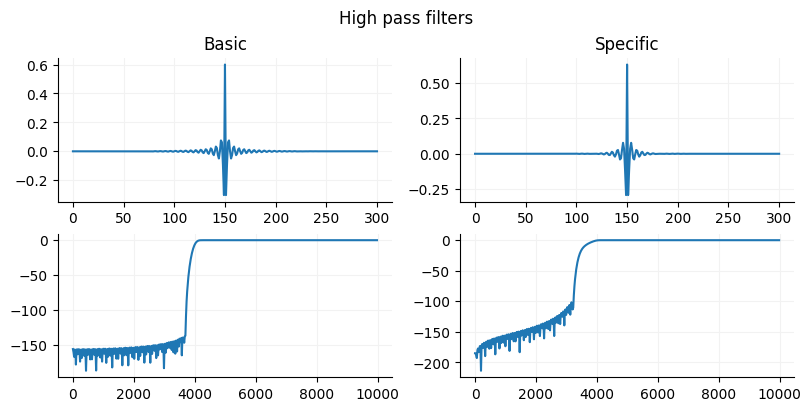

In [13]:
basic_filter = signal.firwin(301, 2000, width=300, pass_zero="highpass", fs=10000)
complex_filter = signal.firwin2(301, [0, 1700, 2000, 5000], gain=[0,0,1,1], window="blackman", fs=10000)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,4), constrained_layout=True)
ax = ax.flat
fig.suptitle("High pass filters")
ax[0].set_title("Basic")
ax[0].plot(basic_filter)
ax[1].plot(complex_filter)
ax[1].set_title("Specific")
w, h = signal.freqz(basic_filter)
ax[2].plot(w*(10000/np.pi), 20*np.log10(np.abs(h)))
w, h = signal.freqz(complex_filter)
ax[3].plot(w*(10000/np.pi), 20*np.log10(np.abs(h)))
for a in ax:
    format_ax(a)

#### Filtering with an FIR filter in Python
To actually use the FIR filter you can use Scipy's [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter) or [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html#scipy.signal.filtfilt). These filters take (b, a) filters or a filter with a numerator (b) and a denominator (a). The _b_ part of the filter is the array that firwin and firwin2 outputs. The _a_ part of the filter is just 1.0. The reason is that the standard output of firwin and firwin2 filters are normalized so that the area under curve is 1 so we don't need a denominator. You could also pass an array of 1s to lfilter or filtfilt that is the same size as the input window (just pass np.ones(window.size)). _lfilter_ only filters in one direction and will shift the phase of the signal by about `window_size/2` where as filtfilt filters in both directions thus is zero phase. You can see the difference betwee the two below as well as a comparison between a _kaiser_ and _blackman_ window.

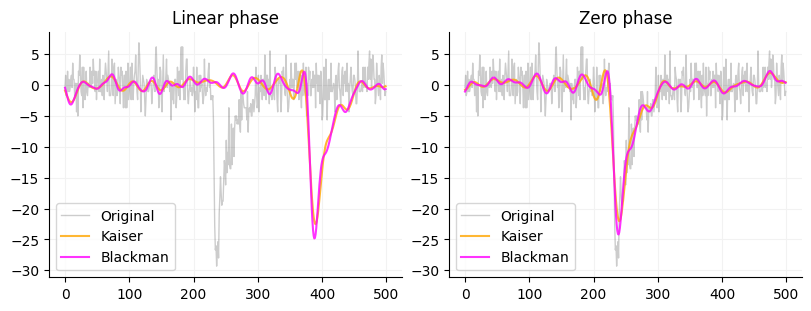

In [14]:
array1 = mepsc.copy()
array1 -= array1.mean()
basic_filter = signal.firwin(301, 400, width=300, fs=10000)
complex_filter = signal.firwin2(301, [0, 400, 700, 5000], gain=[1,1,0,0], window="blackman", fs=10000)
kaiser = signal.lfilter(basic_filter, 1.0, array1)[2750:3250]
blackman = signal.lfilter(complex_filter, 1.0, array1)[2750:3250]
x = np.arange(kaiser.size)
fig, ax = plt.subplots(ncols=2, figsize=(8,3), constrained_layout=True)
ax[0].set_title("Linear phase")
ax[0].plot(x, array1[2750:3250], color="black", linewidth=1, alpha=0.2, label="Original")
ax[0].plot(x, kaiser, color="orange", alpha=0.8, label="Kaiser")
ax[0].plot(x, blackman, color="magenta", alpha=0.8, label="Blackman")
ax[0].legend()
kaiser = signal.filtfilt(basic_filter, 1.0, array1)[2750:3250]
blackman = signal.filtfilt(complex_filter, 1.0, array1)[2750:3250]
x = np.arange(kaiser.size)
ax[1].set_title("Zero phase")
ax[1].plot(x, array1[2750:3250], color="black", linewidth=1, alpha=0.2, label="Original")
ax[1].plot(x, kaiser, color="orange", alpha=0.8, label="Kaiser")
ax[1].plot(x, blackman, color="magenta", alpha=0.8, label="Blackman")
_ = ax[1].legend()
for a in ax:
    format_ax(a)

### What do we use filters for?
Filters are primarily used to filter out unwanted noise in a signal. You can also use filters to recover signals such as single unit spikes from in-vivo electrophysiology. You can use filter to get specific bands from EEG or LFP signals such as theta, beta and gamma. You can use filters to separate out your signal of interest from a carrier signal (frequency or amplitude modulated signals). You can use filters to reduce the effects of aliasing due to converting analog to digital signals. Filters are useful for band limiting a signal that can then be used for Hilbert transforms.

## Peak finding
Peak finding is used a lot in electrophysiological applications because we are often looking for discrete events. There are several ways you look for peaks in your signal using functions provided by Scipy. The most comprehensive peak finding tool is Scipy's [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks), there is the local maxima and minima functions, [argrelmax](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax) and [argrelmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmin.html#scipy.signal.argrelmin) and there is a wavelet based method [find_peaks_cwt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html#scipy.signal.find_peaks_cwt).

## Scipy find_peaks function arguments
Scipy's `find_peaks` can find peaks above a threshold using the `height` argument such as finding whole cell current clamp spikes above 0 mV which we used the [current clamp chapter](#cc_pt1). There is the `prominence` argument which finds peaks based on relative height or amplitude (height normalized to a baseline) which you can read more about [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences). There is the `width` argument which specifies how many samples the peak must be at the half-width or full-width. There is the `distance` function which is the minimal number of samples between peaks. If two peaks are less than the minimal distance the large peak is used. The `threshold` is the distance of the peak sample from its neighboring samples. I have never used this before but could be useful for finding fast peaks (peaks with a fast velocity) or slow peaks.

### Finding peaks when you don't know the threshold
One problem you will encounter with finding peaks is that you may not have a known threshold if your signals vary in power. There are two ways I generally approach this issue. One is a distribution based approach. You can use the mean plus the some fraction or multiple of the standard deviation of all the signal values to set a threshold. This works well for oscillatory signals. If you have an enveloped signal, values that go from 0 to infinity, then your distribution will not be normally distributed. At this point you can either use a percentile cutoff which I find works well in a lot of situations or you can log transform your values then take the mean and standard deviation and back transform them. The percentile method is what I use to find m/sPSCs (see [Miniature/spontaneous postsynaptic currents: Part 1](#mspsc_pt1)). The percentile method works particularly well with point processes that are binarized (1s and 0s) and can also be less variable than using the mean and standard deviation. Setting the minimal number of samples between peaks is also very helpful in getting rid of small peaks if you do not want them.